# Hegslemann Krause Model

[Introductory slides](opinion-dynamics.pdf)

In [1]:
import random
import numpy as np
import math
import pylab
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
from ipywidgets import interact, interactive, fixed, interact_manual
sns.set()

In [2]:
from mesa import Agent, Model
from mesa.time import RandomActivation, SimultaneousActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector


## HK Model 

1. $T\in [0, 1]$ is the truth
2. $\tau\in [0, 1]$ is the truth seeking 
3. $x_{i,t}\in [0, 1]$: agent $i$'s opinion at time $t$
4. $\epsilon\in [0, 1]$ is the agent's bounded confidence parameter
5. $N(i,t)$: agent $i$'s confidants at time $t$: $N(i,t)=\{j\mid |x_{i,t} - x_{j,t}| < \epsilon\}$

$$x_{i,t+1} = \tau \times T + (1-\tau) * \frac{\sum_{j\in N(i,t)} x_{j,t}}{|N(i,t)|}$$

In [3]:
class Expert(Agent):

    def __init__(self, unique_id,  model, init_opinion, conf, truth_seeking, noise = 0):

        super().__init__(unique_id, model)
        self.opinion = init_opinion
        self.old_opinion = init_opinion
        self.conf = conf  
        self.truth_seeking = truth_seeking
    
    
    def update(self):
        
        self.old_opinion = self.opinion
        if self.conf == 0: 
            confidants_opinions = [self.old_opinion]
        else:

            confidants_opinions = [a.old_opinion for a in self.model.schedule.agents 
                                  if math.fabs(self.old_opinion - a.old_opinion) < self.conf]

        self.opinion = self.truth_seeking * self.model.truth + (1-self.truth_seeking)*np.average(confidants_opinions)
                
    def update_asynch(self):
        
        #self.old_opinion = self.opinion
        
        if self.conf == 0: 
            confidants_opinions = [self.opinion]
        else:
            confidants_opinions = [a.opinion for a in self.model.schedule.agents 
                                  if math.fabs(self.opinion - a.opinion) < self.conf]

        self.opinion = self.truth_seeking * self.model.truth + (1-self.truth_seeking)*np.average(confidants_opinions)

class DeliberationModel(Model):
    def __init__(self, num_experts, truth, conf, truth_seeking, simultaneous_update=True):
        
        self.num_experts = num_experts
        self.truth = truth
        self.truth_seeking = truth_seeking
        self.conf = conf
        self.simultaneous_update = simultaneous_update
        
        self.schedule = RandomActivation(self)
        
        self.running = True
        
        # Set up agents
        agent_id = 0
        for i in range(num_experts): 
            init_opinion = random.random()
            e = Expert(i, self, init_opinion, conf, truth_seeking)
            self.schedule.add(e)
        self.datacollector = DataCollector(
            agent_reporters={"opinion": "opinion"})
        
    def step(self):
        for e in self.schedule.agents:
            
            if self.simultaneous_update: 
                
                e.update()
            else: 
                e.update_asynch()
            self.schedule.steps += 1
        


In [4]:
num_agents = 50
conf = 0.05 #  0.2, 0.15,   0.3, 0.25
truth_seeking = 0.1
truth = 0.7

m_simult = DeliberationModel(num_agents, truth, conf, truth_seeking)
m_async = DeliberationModel(num_agents, truth, conf, truth_seeking, simultaneous_update = False)

num_trials = 20
expert_opinions = {e.unique_id:[e.opinion] for e in m_simult.schedule.agents }
expert_opinions_async = {e.unique_id:[e.opinion] for e in m_async.schedule.agents }
for num_trials in range(num_trials): 
    m_simult.step()
    for e in m_simult.schedule.agents: 
        expert_opinions[e.unique_id].append(e.opinion)
    
    m_async.step()
    for e in m_async.schedule.agents: 
        expert_opinions_async[e.unique_id].append(e.opinion)
        


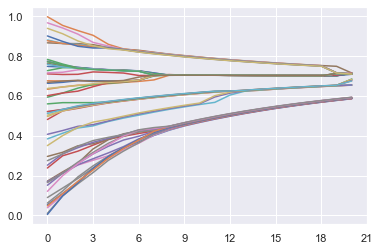

In [5]:
df = pd.DataFrame(expert_opinions)

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

for e in m_simult.schedule.agents: 
    plt.plot(list(df[e.unique_id]))    
plt.show();

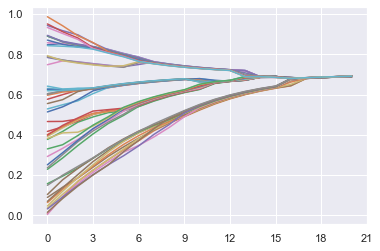

In [6]:
df = pd.DataFrame(expert_opinions_async)

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

for e in m_async.schedule.agents: 
    plt.plot(list(df[e.unique_id]))    
plt.show();

## HK Model  with noise

1. $T\in [0, 1]$ is the truth
2. $\tau\in [0, 1]$ is the truth seeking 
3. $x_{i,t}\in [0, 1]$: agent $i$'s opinion at time $t$
4. $\epsilon\in [0, 1]$ is the agent's bounded confidence parameter
5. $N(i,t)$: agent $i$'s confidants at time $t$: $N(i,t)=\{j\mid |x_{i,t} - x_{j,t}| < \epsilon\}$
6. $\nu$ is the bound on the noise

$$x_{i,t+1} = \tau \times (T + \mathrm{rnd}([-\nu, \nu])) + (1-\tau) * \frac{\sum_{j\in N(i,t)} x_{j,t}}{|N(i,t)|}$$

where $\mathrm{rnd}([-\nu, \nu])$ is a number drawn from a uniform distribution over the interval $[-\nu, \nu]$.  

In [7]:

class Expert(Agent):

    def __init__(self, unique_id,  model, init_opinion, conf, truth_seeking, noise = 0):

        super().__init__(unique_id, model)
        self.opinion = init_opinion
        self.old_opinion = init_opinion
        self.conf = conf # confidence level
        self.truth_seeking = truth_seeking
        self.noise = noise
    
    def update(self):
        
        self.old_opinion = self.opinion
        confidants_opinions = [a.old_opinion for a in self.model.schedule.agents 
                              if math.fabs(self.old_opinion - a.old_opinion) < self.conf]
        
        self.opinion = np.average(confidants_opinions)
    
    def update_with_truth_seeking(self):
        
        self.old_opinion = self.opinion
        if self.conf == 0: 
            confidants_opinions = [self.old_opinion]
        else:

            confidants_opinions = [a.old_opinion for a in self.model.schedule.agents 
                                  if math.fabs(self.old_opinion - a.old_opinion) < self.conf]

        self.opinion = self.truth_seeking * self.model.truth + (1-self.truth_seeking)*np.average(confidants_opinions)

    def update_with_noisy_truth_seeking(self):
        
        noise = np.random.uniform(-self.noise,self.noise,1)[0]
        self.old_opinion = self.opinion
        if self.conf == 0: 
            confidants_opinions = [self.old_opinion]
        else:

            confidants_opinions = [a.old_opinion for a in self.model.schedule.agents 
                                  if math.fabs(self.old_opinion - a.old_opinion) < self.conf]

        self.opinion = self.truth_seeking * (self.model.truth + noise) + (1-self.truth_seeking)*np.average(confidants_opinions)

                
    def update_with_truth_seeking_asynch(self):
        
        #self.old_opinion = self.opinion
        
        if self.conf == 0: 
            confidants_opinions = [self.opinion]
        else:
            confidants_opinions = [a.opinion for a in self.model.schedule.agents 
                                  if math.fabs(self.opinion - a.opinion) < self.conf]

        self.opinion = self.truth_seeking * self.model.truth + (1-self.truth_seeking)*np.average(confidants_opinions)

class DeliberationModel(Model):
    def __init__(self, num_experts, truth, conf, truth_seeking, simultaneous_update=True, noise = 0):
        
        self.num_experts = num_experts
        self.truth = truth
        self.truth_seeking = truth_seeking
        self.conf = conf
        self.simultaneous_update = simultaneous_update
        self.noise = noise
        
        self.schedule = RandomActivation(self)
        
        self.running = True
        
        # Set up agents
        agent_id = 0
        for i in range(num_experts): 
            
            init_opinion = random.random()
            e = Expert(i, self, init_opinion, conf, truth_seeking, noise = self.noise)
            self.schedule.add(e)
        self.datacollector = DataCollector(
            agent_reporters={"opinion": "opinion"})
        
    def step(self):
        for e in self.schedule.agents:
            
            if self.simultaneous_update: 
                
                if self.noise != 0:
                    e.update_with_noisy_truth_seeking()
                else: 
                    e.update_with_truth_seeking()
            else: 
                e.update_with_truth_seeking_asynch()
            self.schedule.steps += 1
        


In [8]:
import ipywidgets as widgets


def run_hk_sim(num_trials, num_agents, conf, truth_seeking, truth, noise):
    m_simult = DeliberationModel(num_agents, truth, conf, truth_seeking, simultaneous_update = True, noise = noise)
    m_async = DeliberationModel(num_agents, truth, conf, truth_seeking, simultaneous_update = False)
    
    expert_opinions = {e.unique_id:[e.opinion] for e in m_simult.schedule.agents }
    expert_opinions_async = {e.unique_id:[e.opinion] for e in m_async.schedule.agents }
    for num_trials in range(num_trials): 
        m_simult.step()
        for e in m_simult.schedule.agents: 
            expert_opinions[e.unique_id].append(e.opinion)

        m_async.step()
        for e in m_async.schedule.agents: 
            expert_opinions_async[e.unique_id].append(e.opinion)
        
    fig, axs = plt.subplots(2, sharex=True, figsize=(11,9))
        
    axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    
    for e in m_simult.schedule.agents: 
        axs[0].plot(expert_opinions[e.unique_id])   
    axs[0].set_title("Simultaneous Updating", fontsize=16)
    for e in m_async.schedule.agents: 
        axs[1].plot(expert_opinions_async[e.unique_id])    
    axs[1].set_title("Asynchronous Updating",fontsize=16)



interact_manual(run_hk_sim, 
         num_trials = widgets.IntSlider(
             value=20,
             min=1,
             max=100,
             step=5,
             description='Num Trials:',
             orientation='horizontal',
             readout=True,
             readout_format='d'
         ),
         num_agents = widgets.IntSlider(
             value=50,
             min=1,
             max=100,
             step=1,
             description='Num Experts:',
             orientation='horizontal',
             readout=True,
             readout_format='d'
         ),
         conf = widgets.FloatSlider(
             value=0.05,
             min=0.0,
             max=1.0,
             step=0.01,
             description='Conf:',
             orientation='horizontal',
             readout=True,
             readout_format='.2f'
         ),
         truth_seeking = widgets.FloatSlider(
             value=0.1,
             min=0.0,
             max=1.0,
             step=0.01,
             description='Truth Seeking:',
             orientation='horizontal',
             readout=True,
             readout_format='.2f'
         ),
        truth = widgets.FloatSlider(
             value=0.7,
             min=0.0,
             max=1.0,
             step=0.1,
             description='Truth:',
             orientation='horizontal',
             readout=True,
             readout_format='.2f'
         ), 
        noise = widgets.FloatSlider(
             value=0.0,
             min=0.0,
             max=1.0,
             step=0.1,
             description='Noise:',
             orientation='horizontal',
             readout=True,
             readout_format='.2f'
         ));

         


interactive(children=(IntSlider(value=20, description='Num Trials:', min=1, step=5), IntSlider(value=50, descr…

## HK Model with noise and reputation

1. $T\in [0, 1]$ is the truth
2. $\tau\in [0, 1]$ is the truth seeking 
3. $x_{i,t}\in [0, 1]$: agent $i$'s opinion at time $t$
4. $\epsilon\in [0, 1]$ is the agent's bounded confidence parameter
5. $N(i,t)$: agent $i$'s confidants at time $t$: $N(i,t)=\{j\mid |x_{i,t} - x_{j,t}| < \epsilon\}$
6. $\nu$ is the bound on the noise
7. For each $j$, $w_j\in [0, 1]$ is the reputation of agent $j$, where $\sum_j w_j = 1$

$$x_{i,t+1} = \tau \times (T + \mathrm{rnd}([-\nu, \nu])) + (1-\tau) * \frac{\sum_{j\in N(i,t)} x_{j,t}\times w_j}{\sum_j w_j}$$

where $\mathrm{rnd}([-\nu, \nu])$ is a number drawn from a uniform distribution over the interval $[-\nu, \nu]$.  

## Further modifications of the HK model

1. All of the  experts always interact with every other expert.  That is, they are supposed to know, at any time, the beliefs of all the other agents. 
2. Learning from the world is a black box. 
3. There is no strategizing or misinformation. 
4. Experts are assumed to have beliefs about a single proposition. What happens when agents have beliefs (either qualitative or quantitative) about multiple propositions (that are possibly logically connected)? 
5. What is the aim of deliberation?  Is it to only reach consensus?  Or do we also want accuracy? 

In [9]:
class Expert(Agent):

    def __init__(self, unique_id, pos, direction, model, init_opinion, conf, truth_seeking, noise = 0):

        super().__init__(unique_id, model)
        self.opinion = init_opinion
        self.old_opinion = init_opinion
        self.conf = conf # confidence level
        self.truth_seeking = truth_seeking
        self.noise = noise
        self.pos = pos
        self.direction = direction
    
    def update(self):
        
        nbhds = self.model.grid.get_neighbors(self.pos, moore = True)
        self.old_opinion = self.opinion
        
        confidants_opinions = [a.old_opinion for a in nbhds 
                               if math.fabs(self.old_opinion - a.old_opinion) < self.conf]

        if len(confidants_opinions) == 0: 
            confidants_opinions = [self.old_opinion]

        self.opinion = self.truth_seeking * self.model.truth + (1-self.truth_seeking)*np.average(confidants_opinions)

    def update_with_noise(self):
        
        noise = np.random.uniform(-self.noise,self.noise,1)[0]
        nbhds = self.model.grid.get_neighbors(self.pos, moore = True)
        self.old_opinion = self.opinion
        
        confidants_opinions = [a.old_opinion for a in nbhds 
                               if math.fabs(self.old_opinion - a.old_opinion) < self.conf]

        if len(confidants_opinions) == 0: 
            confidants_opinions = [self.old_opinion]
        self.opinion = self.truth_seeking * (self.model.truth + noise) + (1-self.truth_seeking)*np.average(confidants_opinions)

    def move(self):
        
        # move to a new cell
        
        nbhds = self.model.grid.get_neighborhood(self.pos, moore = True, include_center=False)
        
        if self.model.grid.is_cell_empty(nbhds[self.direction]):
            self.model.grid.move_agent(self, nbhds[self.direction])
        else: 
            self.direction = random.choice(range(len(nbhds)))

class DeliberationModel(Model):
    def __init__(self, height, width, num_experts, truth, conf, truth_seeking, simultaneous_update=True, noise = 0):
        
        
        self.num_experts = num_experts
        self.truth = truth
        self.truth_seeking = truth_seeking
        self.conf = conf
        self.simultaneous_update = simultaneous_update
        self.noise = noise
        
        self.grid = SingleGrid(width, height, torus=True)
        self.schedule = RandomActivation(self)
        
        self.running = True
        
        # Set up agents
        agent_id = 0
        for i in range(num_experts): 
            
            init_opinion = random.random()
            pos = self.grid.find_empty()
            direction = random.choice(range(len(self.grid.get_neighborhood(pos, moore = True, include_center=False))))
            e = Expert(i, pos, direction, self, init_opinion, conf, truth_seeking, noise = self.noise)
            self.schedule.add(e)
        self.datacollector = DataCollector(
            agent_reporters={"opinion": "opinion"})
        
    def step(self):
        for e in self.schedule.agents:
                
            if self.noise != 0:
                e.update_with_noise()
            else: 
                e.update()
            e.move()
            self.schedule.steps += 1
        


In [10]:
height, width = 25, 25

num_agents = 200
conf = 0.1 #  0.2, 0.15,   0.3, 0.25
truth_seeking = 0.01
truth = 0.7
noise = 0.1

m = DeliberationModel(height, width, num_agents, truth, conf, truth_seeking, noise)

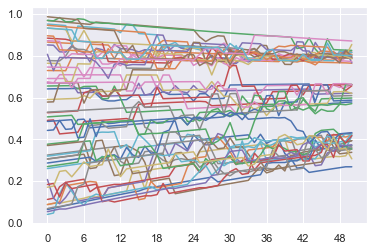

In [11]:
num_trials = 50

expert_opinions = {e.unique_id:[e.opinion] for e in m.schedule.agents }
for t in range(num_trials): 
    m.step()
    for e in m.schedule.agents: 
        expert_opinions[e.unique_id].append(e.opinion)

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

for e in m_simult.schedule.agents: 
    plt.plot(list(expert_opinions[e.unique_id]))    
plt.show();        


## Other Pooling Functions

In [12]:
from functools import reduce

def linear_pool(probs,weights=None):
    """Linear"""
    
    _weights =  weights if weights is not None else [float(1) / float(len(probs)) for p in probs]
    return sum(w*p for w,p in zip(_weights,probs))


def geometric_pool(probs,weights=None):
    """Geometric"""
    
    _weights =  weights if weights is not None else [float(1) / float(len(probs)) for p in probs]
    
    c = reduce(lambda x, y: x*y, [p**w for p,w in zip(probs,_weights)])  + reduce(lambda x, y: x*y, [(1-p)**w for p,w in zip(probs,_weights)])
    return float(reduce(lambda x, y: x*y, [p**w for p,w in zip(probs,_weights)])) / float(c)


def multiplicative_pool(probs):
    """Multiplicative"""
    
    weights = [float(1) for p in probs]
    
    return geometric_pool(probs,weights=weights)

pooling_methods = {
    "Linear": linear_pool,
    "Geometric": geometric_pool,
    "Multiplicative": multiplicative_pool
}

In [13]:
class Expert(Agent):

    def __init__(self, unique_id,  model, init_opinion, conf, truth_seeking, pooling_method, noise = 0):

        super().__init__(unique_id, model)
        self.opinion = init_opinion
        self.old_opinion = init_opinion
        self.conf = conf # confidence level
        self.truth_seeking = truth_seeking
        self.noise = noise
        self.pooling_method = pooling_method
    
    def update(self):
        
        self.old_opinion = self.opinion
        confidants_opinions = [a.old_opinion for a in self.model.schedule.agents 
                              if math.fabs(self.old_opinion - a.old_opinion) < self.conf]
        
        self.opinion = self.pooling_method(confidants_opinions)
    
    def update_with_truth_seeking(self):
        
        self.old_opinion = self.opinion
        if self.conf == 0: 
            confidants_opinions = [self.old_opinion]
        else:

            confidants_opinions = [a.old_opinion for a in self.model.schedule.agents 
                                  if math.fabs(self.old_opinion - a.old_opinion) < self.conf]

        self.opinion = self.truth_seeking * self.model.truth + (1-self.truth_seeking)*self.pooling_method(confidants_opinions)

    def update_with_noisy_truth_seeking(self):
        
        noise = np.random.uniform(-self.noise,self.noise,1)[0]
        self.old_opinion = self.opinion
        if self.conf == 0: 
            confidants_opinions = [self.old_opinion]
        else:

            confidants_opinions = [a.old_opinion for a in self.model.schedule.agents 
                                  if math.fabs(self.old_opinion - a.old_opinion) < self.conf]

        self.opinion = self.truth_seeking * (self.model.truth + noise) + (1-self.truth_seeking)*self.pooling_method(confidants_opinions)

                
    def update_with_truth_seeking_asynch(self):
        
        #self.old_opinion = self.opinion
        
        if self.conf == 0: 
            confidants_opinions = [self.opinion]
        else:
            confidants_opinions = [a.opinion for a in self.model.schedule.agents 
                                  if math.fabs(self.opinion - a.opinion) < self.conf]

        self.opinion = self.truth_seeking * self.model.truth + (1-self.truth_seeking)*self.pooling_method(confidants_opinions)

class DeliberationModelMultiplePooling(Model):
    def __init__(self, num_experts, truth, conf, truth_seeking, simultaneous_update=True, noise = 0, pooling_method = linear_pool):
        
        self.num_experts = num_experts
        self.truth = truth
        self.truth_seeking = truth_seeking
        self.conf = conf
        self.simultaneous_update = simultaneous_update
        self.noise = noise
        self.pooling_method = pooling_method
        self.schedule = RandomActivation(self)
        
        self.running = True
        
        # Set up agents
        agent_id = 0
        for i in range(num_experts): 
            
            init_opinion = random.random()
            e = Expert(i, self, init_opinion, conf, truth_seeking, self.pooling_method, noise = self.noise)
            self.schedule.add(e)
        self.datacollector = DataCollector(
            agent_reporters={"opinion": "opinion"})
        
    def step(self):
        for e in self.schedule.agents:
            
            if self.simultaneous_update: 
                
                if self.noise != 0:
                    e.update_with_noisy_truth_seeking()
                else: 
                    e.update_with_truth_seeking()
            else: 
                e.update_with_truth_seeking_asynch()
            self.schedule.steps += 1
        


In [14]:
def run_hk_sim2(num_trials, num_agents, conf, truth_seeking, truth, noise, pooling_method_str):
    
    m_simult = DeliberationModelMultiplePooling(num_agents, 
                                                truth, 
                                                conf, 
                                                truth_seeking, 
                                                simultaneous_update = True, 
                                                noise = noise, 
                                                pooling_method = pooling_methods[pooling_method_str])
    m_async = DeliberationModelMultiplePooling(num_agents, 
                                               truth, 
                                               conf, 
                                               truth_seeking, 
                                               simultaneous_update = False,
                                               pooling_method = pooling_methods[pooling_method_str])
    
    expert_opinions = {e.unique_id:[e.opinion] for e in m_simult.schedule.agents }
    expert_opinions_async = {e.unique_id:[e.opinion] for e in m_async.schedule.agents }
    for num_trials in range(num_trials): 
        m_simult.step()
        for e in m_simult.schedule.agents: 
            expert_opinions[e.unique_id].append(e.opinion)

        m_async.step()
        for e in m_async.schedule.agents: 
            expert_opinions_async[e.unique_id].append(e.opinion)
        
    fig, axs = plt.subplots(2, sharex=True, figsize=(11,9))
        
    axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    
    for e in m_simult.schedule.agents: 
        axs[0].plot(expert_opinions[e.unique_id])   
    axs[0].set_title("Simultaneous Updating", fontsize=16)
    for e in m_async.schedule.agents: 
        axs[1].plot(expert_opinions_async[e.unique_id])    
    axs[1].set_title("Asynchronous Updating",fontsize=16)



interact_manual(run_hk_sim2, 
         num_trials = widgets.IntSlider(
             value=20,
             min=1,
             max=100,
             step=5,
             description='Num Trials:',
             orientation='horizontal',
             readout=True,
             readout_format='d'
         ),
         num_agents = widgets.IntSlider(
             value=50,
             min=1,
             max=100,
             step=1,
             description='Num Experts:',
             orientation='horizontal',
             readout=True,
             readout_format='d'
         ),
         conf = widgets.FloatSlider(
             value=0.05,
             min=0.0,
             max=1.0,
             step=0.01,
             description='Conf:',
             orientation='horizontal',
             readout=True,
             readout_format='.2f'
         ),
         truth_seeking = widgets.FloatSlider(
             value=0.1,
             min=0.0,
             max=1.0,
             step=0.01,
             description='Truth Seeking:',
             orientation='horizontal',
             readout=True,
             readout_format='.2f'
         ),
        truth = widgets.FloatSlider(
             value=0.7,
             min=0.0,
             max=1.0,
             step=0.1,
             description='Truth:',
             orientation='horizontal',
             readout=True,
             readout_format='.2f'
         ), 
        noise = widgets.FloatSlider(
             value=0.0,
             min=0.0,
             max=1.0,
             step=0.1,
             description='Noise:',
             orientation='horizontal',
             readout=True,
             readout_format='.2f'
         ),
         pooling_method_str = widgets.Dropdown(
             value="Linear",
             options = ["Linear", "Geometric", "Multiplicative"],
             description = "Pooling Method: ",
             readout=True,
         ));

         


interactive(children=(IntSlider(value=20, description='Num Trials:', min=1, step=5), IntSlider(value=50, descr…

In [15]:
import copy 
class Expert2(Agent):

    def __init__(self, unique_id,  model, init_opinion, conf, truth_seeking, pooling_methods, noise = 0):

        super().__init__(unique_id, model)
        self.opinion = {pm.__doc__: init_opinion for pm in pooling_methods}
        self.old_opinion = {pm.__doc__: init_opinion for pm in pooling_methods}
        self.conf = conf # confidence level
        self.truth_seeking = truth_seeking
        self.noise = noise
        self.pooling_methods = pooling_methods
    
    
    def update_with_truth_seeking(self):
        for pm in self.pooling_methods:
            self.old_opinion[pm.__doc__] = copy.deepcopy(self.opinion[pm.__doc__])
            if self.conf == 0: 
                confidants_opinions = [self.old_opinion[pm.__doc__]]
            else:

                confidants_opinions = [a.old_opinion[pm.__doc__] for a in self.model.schedule.agents 
                                      if math.fabs(self.old_opinion[pm.__doc__] - a.old_opinion[pm.__doc__]) < self.conf]
            
            self.opinion[pm.__doc__] = self.truth_seeking * self.model.truth + (1-self.truth_seeking)* pm(confidants_opinions)
    def update_with_noisy_truth_seeking(self):
        
        noise = np.random.uniform(-self.noise,self.noise,1)[0]
        for pm in self.pooling_methods:
            self.old_opinion[pm.__doc__] = copy.deepcopy(self.opinion[pm.__doc__])
            if self.conf == 0: 
                confidants_opinions = [self.old_opinion[pm.__doc__]]
            else:

                confidants_opinions = [a.old_opinion[pm.__doc__] for a in self.model.schedule.agents 
                                      if math.fabs(self.old_opinion[pm.__doc__] - a.old_opinion[pm.__doc__]) < self.conf]

            self.opinion[pm.__doc__] = self.truth_seeking * (self.model.truth + noise) + (1-self.truth_seeking)*pm(confidants_opinions)

                
class DeliberationModelMultiplePooling2(Model):
    def __init__(self, num_experts, truth, conf, truth_seeking, simultaneous_update=True, noise = 0, pooling_methods = [linear_pool]):
        
        self.num_experts = num_experts
        self.truth = truth
        self.truth_seeking = truth_seeking
        self.conf = conf
        self.simultaneous_update = simultaneous_update
        self.noise = noise
        self.pooling_methods = pooling_methods
        self.schedule = RandomActivation(self)
        
        self.running = True
        
        # Set up agents
        agent_id = 0
        for i in range(num_experts): 
            
            init_opinion = random.random()
            e = Expert2(i, self, init_opinion, conf, truth_seeking, self.pooling_methods, noise = self.noise)
            self.schedule.add(e)
        
    def step(self):
        for e in self.schedule.agents:
             
            if self.noise != 0:
                e.update_with_noisy_truth_seeking()
            else: 
                e.update_with_truth_seeking()
            self.schedule.steps += 1
        


In [16]:
def run_hk_sim3(num_trials, num_agents, conf, truth_seeking, truth, noise):
    
    m = DeliberationModelMultiplePooling2(num_agents, 
                                          truth, 
                                          conf, 
                                          truth_seeking,
                                          noise = noise,
                                          pooling_methods = [linear_pool, geometric_pool, multiplicative_pool])
    
    expert_opinions_linear = {e.unique_id: [e.opinion["Linear"]] for e in m.schedule.agents }
    expert_opinions_geometric = {e.unique_id: [e.opinion["Geometric"]] for e in m.schedule.agents }
    expert_opinions_mult = {e.unique_id: [e.opinion["Multiplicative"]] for e in m.schedule.agents }
    for num_trials in range(num_trials): 
        m.step()
        for e in m.schedule.agents: 
            expert_opinions_linear[e.unique_id].append(e.opinion["Linear"])
            expert_opinions_geometric[e.unique_id].append(e.opinion["Geometric"])
            expert_opinions_mult[e.unique_id].append(e.opinion["Multiplicative"])
    
    fig, axs = plt.subplots(3, sharex=True, figsize=(11,9))
        
    axs[2].xaxis.set_major_locator(MaxNLocator(integer=True))
    
    for e in m.schedule.agents: 
        axs[0].plot(expert_opinions_linear[e.unique_id])   
    axs[0].set_title("Linear Pooling", fontsize=16)
    for e in m.schedule.agents: 
        axs[1].plot(expert_opinions_geometric[e.unique_id])   
    axs[1].set_title("Geometric Pooling", fontsize=16)
    for e in m.schedule.agents: 
        axs[2].plot(expert_opinions_mult[e.unique_id])   
    axs[2].set_title("Multiplicative Pooling", fontsize=16)
    
    axs[0].set_ylim(0, 1)


interact_manual(run_hk_sim3, 
         num_trials = widgets.IntSlider(
             value=20,
             min=1,
             max=100,
             step=5,
             description='Num Trials:',
             orientation='horizontal',
             readout=True,
             readout_format='d'
         ),
         num_agents = widgets.IntSlider(
             value=50,
             min=1,
             max=100,
             step=1,
             description='Num Experts:',
             orientation='horizontal',
             readout=True,
             readout_format='d'
         ),
         conf = widgets.FloatSlider(
             value=0.05,
             min=0.0,
             max=1.0,
             step=0.01,
             description='Conf:',
             orientation='horizontal',
             readout=True,
             readout_format='.2f'
         ),
         truth_seeking = widgets.FloatSlider(
             value=0.1,
             min=0.0,
             max=1.0,
             step=0.01,
             description='Truth Seeking:',
             orientation='horizontal',
             readout=True,
             readout_format='.2f'
         ),
        truth = widgets.FloatSlider(
             value=0.7,
             min=0.0,
             max=1.0,
             step=0.1,
             description='Truth:',
             orientation='horizontal',
             readout=True,
             readout_format='.2f'
         ), 
        noise = widgets.FloatSlider(
             value=0.0,
             min=0.0,
             max=1.0,
             step=0.1,
             description='Noise:',
             orientation='horizontal',
             readout=True,
             readout_format='.2f'
         ));

         


interactive(children=(IntSlider(value=20, description='Num Trials:', min=1, step=5), IntSlider(value=50, descr…

 
 
In an ideal situation, the discussion will elicit from each member of the group not only their judgements, but also their reasons, arguments and evidence that back up these judgements. Through discussion and debate, the group can sort through all of the evidence and arguments leading to a more informed solution.

 

A common criticism of unstructured group discussion is that it enhances cognitive errors rather than mitigates them.


**Bias against the minority**: There is a tendency for groups to ignore isolated, minority or lower-status members. 


**Anchoring effect**: There is a tendency to rely too heavily, or "anchor", a judgement on one piece of information (for example, the first announced judgement, the judgement of the most senior person in the group, or the judgement of the loudest person in the group). 

**Common knowledge effect**: Information held by all members of the group has more influence on the final decision than information held by only a few members of the group.  So, if everybody in  the group has some information, then it is more valuable than the information of just a few members.


What is the best form for social influence to take? Is it better to have more rather than less social influence? Are all policies which aim to increase the amount of interaction over a particular issue likely to be successful in their aims?



 
K. Zollman, (2013), Network epistemology: Communication in epistemic communities, Philosophy
Compass, 8 (1), 15  - 27.

V. Bala  and S. Goyal (1998), Learning from neighbors}{Review of Economic Studies, 65 (3), 595 - 621.


B. Golub and M. O. Jackson (2010), Naive learning in social networks and the wisdom of crowds, American Economic Journal: Microeconomics, pages 112 - 149.
